# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 3


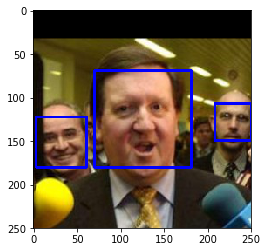

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

vecface_detector = np.vectorize(face_detector)

humans = vecface_detector(human_files_short)
print("Human faces detected: %.2f" % ((humans == True).sum() / 100.0))

dogs = vecface_detector(dog_files_short)
print("Human faces detected (in dog_files): %.2f" % ((dogs == True).sum() / 100.0))

Human faces detected: 0.99
Human faces detected (in dog_files): 0.11


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

For some applications, such as Social Networks, it will be unrealistic to expect that a person will always be looking directly at the camera. In these cases we would need a system that would detect a person's face if they are not looking directly at the camera.

There are other applications where the requirement for the person to look at the camera is expected - in the cases of security systems (biosecurity face scans), a person not only required to look straight at the camera, but they must keep a straight face (no frowning).

For applications where we want to detect the user's face without the requiring them to pose directly at the camera, we could use a neural network. The neural network would need to be trained using pictures of people who are looking in multiple directions - at the camera, to the side, up, down etc. This training data would also need to include pictures of people smiling/sad, and again looking in different directions for the different facial expressions. The pictures would need to be transformed into a 1D vector for input into the neural network; this means that the neural network will need N nodes in the input layer for a vector of N elements. In order to reduce the size of the input layer (and therefore the size of the hidden layers), the pictures would need to be converted to grayscale and the picture size reduced. The transformation of the picture into a 1D vector means that we are losing information relating to spatial features, and these features could be critical to helping to identify a human face. This is not an issue for a convolutional network where spatial information is preserved; the CNN will learn to find features such as edges, lines, shapes etc. When training a CNN, the training data can be increased by applying geometric operations to the original images to generate additional image. The additional images differ from the original images by changing the placement of the subject, skewing (slightly) the image, flipping the image.


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [10]:
vecdog_detector = np.vectorize(dog_detector)

humans = vecdog_detector(human_files_short)
print("Dogs detected in human files: %.2f" % ((dogs == True).sum() / 100.0))

dogs = vecdog_detector(dog_files_short)
print("Dogs detected in dog files: %.2f" % ((dogs == True).sum() / 100.0))

Dogs detected in human files: 0.11
Dogs detected in dog files: 1.00


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 140.86it/s]


In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

from keras.callbacks import ModelCheckpoint

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

For the following architecture, I used 3x3 filters for all layers; generally the layers were arranged in the following pattern of two 3x3 convolutional layers followed by a max pooling layer. For the convolutional layers I used padding to ensure that all data is included from the input layer.

The reason for this architecture is that if we look at AlexNet, ZF Net and VGG Net architectures we can see that there is a trend towards using smaller filers in the first layer to help retain features from the input. For the task of predicting dog breeds it seems critical that we want to retain as much information as possible given that are dog breeds with strong similarities. A stride of 1 was also used to help retain information. Based on the VGG Net architecture, I stacked 3x3 convolutional layers back to back as this will be equivalent to one 5x5 filter - but with 2 3x3 layers we have fewer number of parameters to train.

With the exception of the final dense layer, ReLU activations were used as this activation tends to be faster than tanh or sigmoid activation functions during training - however we may want to use a leaky version of ReLU to avoid neurons becoming dead if the weights go to zero.

Max pooling layers (in all cases, 2x2 filters) were used to reduce the input image (by 2 times in both directions); by reducing the image size (downsampling) we are reducing the number of parameters to be trained, and reduce the memory & cpu load. After each max pooling layer, a dropout layer was added - the dropout layers would drop 20% of the activations during training which helps reduce the risk of the overfitting.

Before the final layer I used a dropout layer to reduce the risk that the model will have "good" accuracy on the training data but would perform badly on new data (overfitting). This layer randomly drops 25% of the activations to the final, fully connected, layer.

The final layer is a dense, fully connected layer with a softmax activation. This layer is performing the final classification. In this task we are predicting the dog breed so the output of the dense layer is a vector that represents the probability for each dog breed. The dense layer looks at what high level features (output from the previous convolutional layer) strongly correlate to a particular dog breed. Further improvements to this architecture may include adding an additional dense layer.

I used 30 epochs during training; judging from the output from the training phase, I could easily increase the number of epochs in order to improve the accuracy of the model - however ideally we would like to implement some early stopping rule (stop training if no improvement after 5 training executions).

In [45]:
# todo: try stride of 1 for max pooling so we don't lose as much info
# todo: try additional dense layer

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=train_tensors.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='valid'))
model.add(Dropout(0.20))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='valid'))
model.add(Dropout(0.20))

model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='valid'))
model.add(Dropout(0.20))

model.add(Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.25))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 64)        0         
__________

### Compile the Model

In [46]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [47]:
epochs = 30

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 109s - loss: 4.8966 - acc: 0.0091 - val_loss: 4.8708 - val_acc: 0.0096
Epoch 2/30
6680/6680 [==============================] - 107s - loss: 4.8543 - acc: 0.0156 - val_loss: 4.8282 - val_acc: 0.0168
Epoch 3/30
6680/6680 [==============================] - 107s - loss: 4.7709 - acc: 0.0169 - val_loss: 4.7042 - val_acc: 0.0180
Epoch 4/30
6680/6680 [==============================] - 107s - loss: 4.7113 - acc: 0.0192 - val_loss: 4.9685 - val_acc: 0.0108
Epoch 5/30
6680/6680 [==============================] - 107s - loss: 4.6521 - acc: 0.0201 - val_loss: 4.7998 - val_acc: 0.0144
Epoch 6/30
6680/6680 [==============================] - 107s - loss: 4.6071 - acc: 0.0269 - val_loss: 4.6582 - val_acc: 0.0359
Epoch 7/30
6680/6680 [==============================] - 107s - loss: 4.5611 - acc: 0.0298 - val_loss: 4.5498 - val_acc: 0.0299
Epoch 8/30
6680/6680 [==============================] - 107s - l

6680/6680 [==============================] - 108s - loss: 2.9408 - acc: 0.2648 - val_loss: 3.1949 - val_acc: 0.2527
Epoch 29/30
6680/6680 [==============================] - 108s - loss: 2.8596 - acc: 0.2766 - val_loss: 3.1367 - val_acc: 0.2419
Epoch 30/30
6680/6680 [==============================] - 108s - loss: 2.8234 - acc: 0.2888 - val_loss: 3.0486 - val_acc: 0.2647


### Load the Model with the Best Validation Loss

In [48]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [49]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 27.1531%


### Use Image Argumentation

In [18]:
from keras.preprocessing.image import ImageDataGenerator

class FixedImageDataGenerator(ImageDataGenerator):
    def standardize(self, x):
        if self.featurewise_center:
            x = ((x/255.) - 0.5) * 2.
        return x

img_width = 224
img_height = 224
batch_size = 20

# apply image transformation - shift & flip images
datagen = FixedImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    'dogImages/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

validation_generator = datagen.flow_from_directory(
    'dogImages/valid',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [19]:

'''
model.fit_generator(
    train_generator,
    samples_per_epoch=(len(train_files) // batch_size),
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=(len(valid_files) // batch_size))
'''

'\nmodel.fit_generator(\n    train_generator,\n    samples_per_epoch=(len(train_files) // batch_size),\n    epochs=epochs,\n    validation_data=validation_generator,\n    nb_val_samples=(len(valid_files) // batch_size))\n'

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [20]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [21]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [22]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [23]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

#VGG16_model.fit(train_VGG16, train_targets, 
#          validation_data=(valid_VGG16, valid_targets),
#          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [24]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [25]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 39.8325%


### Predict Dog Breed with the Model

In [26]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [27]:
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [28]:
Xception_model = Sequential()

Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(680, activation='relu'))
Xception_model.add(Dropout(0.2))
Xception_model.add(Dense(680, activation='relu'))
Xception_model.add(Dropout(0.2))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 680)               1393320   
_________________________________________________________________
dropout_2 (Dropout)          (None, 680)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 680)               463080    
_________________________________________________________________
dropout_3 (Dropout)          (None, 680)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               90573     
Total params: 1,946,973
Trainable params: 1,946,973
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [29]:
from keras import optimizers

Xception_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [30]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=50, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 4s - loss: 4.8854 - acc: 0.0130 - val_loss: 4.8009 - val_acc: 0.0132
Epoch 2/50
6680/6680 [==============================] - 3s - loss: 4.7597 - acc: 0.0311 - val_loss: 4.6817 - val_acc: 0.0874
Epoch 3/50
6680/6680 [==============================] - 3s - loss: 4.6445 - acc: 0.0749 - val_loss: 4.5580 - val_acc: 0.1701
Epoch 4/50
6680/6680 [==============================] - 3s - loss: 4.5153 - acc: 0.1421 - val_loss: 4.4207 - val_acc: 0.2838
Epoch 5/50
6680/6680 [==============================] - 3s - loss: 4.3726 - acc: 0.2162 - val_loss: 4.2638 - val_acc: 0.3701
Epoch 6/50
6680/6680 [==============================] - 3s - loss: 4.2115 - acc: 0.2874 - val_loss: 4.0831 - val_acc: 0.4407
Epoch 7/50
6680/6680 [==============================] - 3s - loss: 4.0277 - acc: 0.3569 - val_loss: 3.8750 - val_acc: 0.4778
Epoch 8/50
6680/6680 [==============================] - 3s - loss: 3.8152 - ac

6680/6680 [==============================] - 3s - loss: 0.9975 - acc: 0.7633 - val_loss: 0.8272 - val_acc: 0.8036
Epoch 27/50
6680/6680 [==============================] - 3s - loss: 0.9721 - acc: 0.7606 - val_loss: 0.7958 - val_acc: 0.8132
Epoch 28/50
6680/6680 [==============================] - 3s - loss: 0.9191 - acc: 0.7704 - val_loss: 0.7696 - val_acc: 0.8120
Epoch 29/50
6680/6680 [==============================] - 3s - loss: 0.8926 - acc: 0.7713 - val_loss: 0.7483 - val_acc: 0.8156
Epoch 30/50
6680/6680 [==============================] - 3s - loss: 0.8640 - acc: 0.7783 - val_loss: 0.7273 - val_acc: 0.8192
Epoch 31/50
6680/6680 [==============================] - 3s - loss: 0.8431 - acc: 0.7811 - val_loss: 0.7109 - val_acc: 0.8204
Epoch 32/50
6680/6680 [==============================] - 3s - loss: 0.8227 - acc: 0.7882 - val_loss: 0.6944 - val_acc: 0.8132
Epoch 33/50
6680/6680 [==============================] - 3s - loss: 0.7922 - acc: 0.7913 - val_loss: 0.6797 - val_acc: 0.8240
Epoc

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [31]:
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [32]:
# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.0144%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [33]:
from extract_bottleneck_features import *

def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [34]:
def classify_image_helper(img_path):
    is_human = face_detector(img_path)
    is_dog = dog_detector(img_path)
    dog_breed = Xception_predict_breed(img_path)
    return (is_dog, is_human, dog_breed)

def classify_image(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    is_dog, is_human, breed = classify_image_helper(img_path)
    if is_dog:
        print(breed)
    if is_human:
        print('Hello human, you look like a... ' + breed)
    if (is_dog == False and is_human == False):
        print('Cannot identify image...')

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

### Detecting Dog Breeds

I picked two pictures of Border Collies to test the algorihm; in both cases the algorithm detects the images as dogs, and classifies the breeds as being either an Australian Sheperd or Collie. I scanned the training images for Australian Sheperds and to me it appears that we may have a problem with the training data - pictures Australian_shepherd_00812.jpg, Australian_shepherd_00815.jpg, Australian_shepherd_00818.jpg, Australian_shepherd_00821.jpg appear to be Collie dogs. If theses pictures are correctly classified then both Collies and Australian Sheperds look very similar and as such the algorithm did a reasonable job.

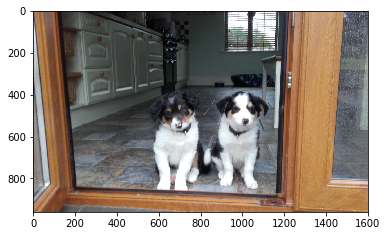

Australian_shepherd


In [35]:
classify_image('images/test/IMG-20160614-WA0000.jpg')

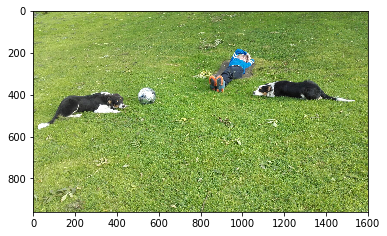

Border_collie


In [36]:
classify_image('images/test/IMG-20160913-WA0004.jpg')

### Detecting People

For the test pictures with people, with one exception, the algorithm always detected that the picture was a person, even when the person was wearing glasses or helmets. For the one picture where the algorithm did not detect a person (it could not identify the picture), I tried a close up of the boy, but the algorithm still failed; the boy needs to be looking directly at the camera.

In the cases where the algorithm correctly identified the subject as human, the person(s) was either classified as a Dachshund (3), Kuvasz, or as a Chinese Crested. In the case where a person was classified as a Chinese Crested, the person was either wearing a bicycle helmet or sunglasses. The classification of Kuvasz is interesting - in the test image, there is a boy holding a soft toy which looks similar to a Kuvasz. The dog breed classifier may be focued on the soft toy and not the boy

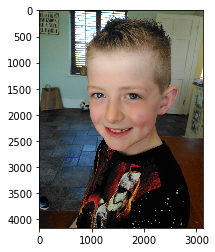

Hello human, you look like a... Plott


In [37]:
classify_image('images/test/IMG_20160514_134805.jpg')

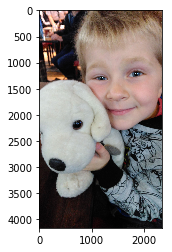

Hello human, you look like a... Kuvasz


In [38]:
classify_image('images/test/IMG-20160813-WA0005.jpeg')

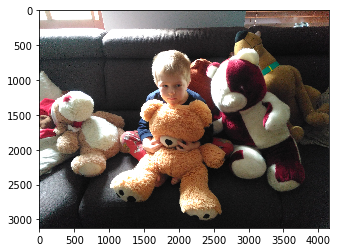

Cannot identify image...


In [39]:
classify_image('images/test/IMG_20170429_082636.jpg')

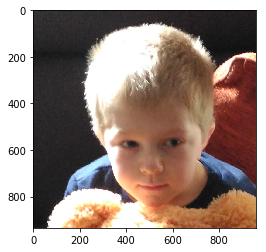

Cannot identify image...


In [40]:
classify_image('images/test/closeup.png')

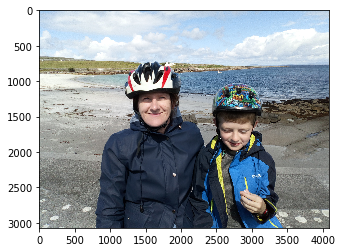

KeyboardInterrupt: 

In [41]:
classify_image('images/test/DSC_0034.JPG')

In [ ]:
classify_image('images/test/DSC_0047.JPG')

In [ ]:
classify_image('images/test/DSC_0025.JPG')

In [ ]:
classify_image('images/test/IMG_20170326_131555.jpg')


### Other Images

For the other images that are not dogs or humans, the algorithm correctly identified the picture as not dog or human.

In [ ]:
classify_image('images/test/IMG_20160601_071428.jpg')

In [ ]:
classify_image('images/test/scoobydoo.jpg')

#### Experiment
What does the model predict for the breed of Scooby Doo?

In [ ]:
print(Xception_predict_breed('images/test/scoobydoo.jpg'))